In [1]:
import os
import numpy as np 
import sympy as s
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
from IPython.display import Markdown, display, Math, HTML

# Involute Spur Gear Geometry Calculations

As derived from industry formulas.

Key features:
* Standard Involute Curve Form
* Profile Shifts 
* Measure over/between Wires

![MOW Gear](assets/ExampleMOW.png)

Some internal scripts for simplification:

In [2]:
A, B = s.symbols("\\alpha \\THeta")
InvoFunc = s.tan(A) - A - B
InvoFuncPrime = s.diff(InvoFunc, A)
#display(Math("0 = %s"%(InvoFunc)), Math("0 = %s"%(InvoFuncPrime)))
InvoFuncLambda = s.lambdify((A,B), InvoFunc, "numpy")
InvoFuncPrimeLambda = s.lambdify(A, InvoFuncPrime, "numpy")

# Newton's Method
def newtons(target, func = InvoFuncLambda, funcPrime = InvoFuncPrimeLambda, initial = 1, tol = 1e-10, max_iter = 1000):
    # Iterative Step Angle
    ang = initial
    for _ in range(max_iter):
        fval = func(ang, target)
        fvalPrime = funcPrime(ang)
        angPlus = ang - fval / fvalPrime
        if np.abs(angPlus - ang) < tol:
            return angPlus
        ang = angPlus
    raise ValueError("Newton Did Not Converge from Inputs")

In [3]:
# Small Dictionary-Adding Solver Function for later brevity
def solve(symbol, dictionary, equation):
    #if sum([symbol == var for var in vars.keys()]) < 1:
    dictionary[symbol] = float(s.solve(equation.subs(dictionary), symbol)[0])
    #else:
    #    display("Already Provided: %s"%symbol)s

## Definition of Terms

Inputs:


$N -$ num :: Number of Teeth

$P - $ Pitch, the spacing from one tooth to another. Most easily thought about as circular pitch $P_C$, along the circumference, but often used on the Diametral basis $P_D$. Note that $P_C$ spans both a tooth and space, but $P_D$ is in a sense only 'describes' the teeth, and therefore differs by factor 2.

__Input Values__

| Var | Unit | Name | Formula | Note
|:----:|:----:|:----:|:----:|:----:|
| $N$ |  - | Number of Teeth | - 
| $P$ | in/in | Pitch | - | Tooth-to-tooth spacing
| $P_C$ | in/in | Pitch, Circumferential | $\frac{2 \pi}{P_D} \times \frac{1}{2} \rightarrow \frac{\pi}{P_D}$ | Describes tooth-to-tooth (tooth+space)
| $P_D$ | in/in | Pitch, Diameteral | $\frac{\pi}{P_C}$ | Describes tooth-to-space (tooth only)
| $\beta$ | RAD | Pressure Angle, Definitional | - | The tooth-curve pressure angle
| $\gamma$ | RAD | Helix Angle (helical gear) | - 
| $L_b$ | in | Backlash | - 
| $CTC$ | in | Center to Center Distance | -
| $H_f$ | in/in | Adjustment of Height, Minor Diameter | - 
| $D_{pin}$ | in | Measurement Pin Diameter | - 
| $Lead$ | in | Lead | - | Helical displacement of tooth from straight axis line.

__Calculation Values__

| Var | Unit | Name | Formula | Note
|:----:|:----:|:----:|:----:|:----:|
| $D_P$ | in | Diameter, Pitch | $\frac{N}{P_D}$ | -
| $D_{base}$ | in | Diameter, Base | - | Starting Diameter of Involute Profile Generation
| $D_{form}$ | in | Diameter, Form | - | Start of Actual Involute Form; relevant in undercut or modified fillet gears.
| $CTT$ | in | Circular Tooth Thickness | - | By default equals $P_C/2$, but will change due to modifications (backlash)
| $CSW$ | in | Circular Space Width | $P_C - CTT$ | Used as basis instead of CTT for internal gears.
| $D_{add}$ | in | Diameter, Addendum | $\frac{N+2}{P_D}$ | The "top" of the gear tooth. Standardized formula shown, though it is open for adjustment
| $D_{ded}$ | in | Diameter, Dedendum | $D_P - \frac{2 H_f}{P_D}$ | The bottom (root) of the gear
| $MOW/MBW$ | in | Measure Over/Between Wires | __See below__ | Caliper dimension over gage pins. Useful for determining CSW/CTT, and therefore profile adjustments, in applications.
| $\alpha$ | RAD | Pressure Angle, Curve | __See below__ | The variable for pressure angle as it evolves along the curve form; distinct from the curve definition pressure angle $\beta$


**Modifiers:**

$/e/$ Equation

$/trv/$ Transverse _(for non-straight teeth ~ helical)_

$/m/$ Maximum

$/n/$ Minimum

$/a/$ Average

$/u/$ Upper Tolerance

$/l/$ Lower Tolerance

$/r/$ Roughing

In [4]:
N, Pd, Beta, Gamma, Hf, Dpin, CTC = s.symbols("N P_d \\beta \\gamma H_f D_{pin} CTC")
Dp, Dbase, Dadd, Dded, Dform = s.symbols("D_p D_{base} D_{add} D_{ded} D_{form}")

CTT, CSW = s.symbols("CTT CSW")
CTTstd, CSWstd = s.symbols("CTT_{std} CSW_{std}")

tBeta, tGamma, tDpin = s.symbols("\\beta_{trv} \\gamma_{trv} D_{pin-trv}")
rSTK, raCTT = s.symbols("STK CTT_{avg-roughing}")
AlpStart = s.symbols("\\alpha_{start}")


In [5]:
eDp = s.Eq(Dp, N / Pd)

etBeta = s.Eq(tBeta, s.atan( s.tan(Beta) / s.cos(Gamma) ))

eDbase = s.Eq(Dbase, Dp * s.cos( tBeta ), evaluate = False )

etGamma = s.Eq(tGamma, s.atan( s.tan(Gamma) * s.cos(tBeta)))

eCTTstd = s.Eq(CTTstd, Dp * s.pi / N /2)

eCSW = s.Eq(CSW, (Dp * s.pi / N) - CTT)

eDadd = s.Eq(Dadd, (N + 2)/ Pd)

eDded = s.Eq(Dded, Dp - 2 * (Hf/Pd) )

etDpin = s.Eq(tDpin, Dpin / s.cos(tGamma))

In [6]:
display(eDp, etBeta, eDbase, etGamma, eDadd, eDded, etDpin)

Eq(D_p, N/P_d)

Eq(\beta_{trv}, atan(tan(\beta)/cos(\gamma)))

Eq(D_{base}, D_p*cos(\beta_{trv}))

Eq(\gamma_{trv}, atan(cos(\beta_{trv})*tan(\gamma)))

Eq(D_{add}, (N + 2)/P_d)

Eq(D_{ded}, D_p - 2*H_f/P_d)

Eq(D_{pin-trv}, D_{pin}/cos(\gamma_{trv}))

## MOW Max & Min

### Formulas & Explanation

Determining the distance of the MOW/MBW requires an understanding of where the gage pin will rest along the involute curve of the gear tooth. The first step is determining the __involute angle__ $\Theta$ at which the pin will be able to contact the form; from there, there is a relationship of $\Theta$ to the __pressure angle__ $\alpha$, though it must be solve non-algebraically. With known pressure, the actual location of the pin contact along the tooth form is defined, and as such a final formula may be used to span the base diameter and the pin diameter.

1) Involute Angle $\Theta$

$\Theta_{m|n} = (\frac{CTT_{m|n}}{D_P cos(\gamma)}  - \frac{\pi}{N}) + (tan(\beta_{trv}) - \beta_{trv}) + \frac{D_{pin-trv}}{D_{base}}$

* The $\frac{CTT}{D_P}$ term determines the radian angle offset from the center of the tooth spacing, with the basic distance being the $\pi/N$ ; dividing by $cos(\gamma)$ adjusts this for an helix angle.

* The $tan(\beta_{trv}) - \beta_{trv}$ term is the wrap angle output at the definitional pressure angle, as found at the pitch diameter (importantly, the same diameter as the CTT is measured). This is a component of the offsetting from the CTT line to the involute start location.

* The $\frac{D_{pin}}{D_{base}}$ term is an additional offset accounting for the pin diameter as it must rest between the teeth; _the physical representation of this radian term is to be determined_.


2) Variable Pressure Angle $\alpha$

$\Theta_{m|n} = tan(\alpha_{m|n}) - \alpha_{m|n}$

* There is no discrete formula for deriving the pressure angle from the given involute angle; it must be calculated through numerical means.

* As example, _Newton's Method_. To do this requires taking the derivative of the involute function, to arrive at $\dot{\Theta} = tan^2(\alpha)$; see the _newtons_ script in the header.

3) Measure Over Wires

For even tooth number (gage pins directly opposing):

$MOW_{m|n} = D_{pin} + \frac{D_{base}}{cos(\alpha_{m|n})}$

For odd tooth number (gage pin opposes a tooth):

$MOW_{m|n} = D_{pin} + \frac{D_{base}}{cos(\alpha_{m|n})} \times cos(\frac{\pi}{2N})$

In [7]:
mAlpha, nAlpha = s.symbols("\\alpha_{max}, \\alpha_{min}")
mInvo, nInvo = s.symbols("Involute_{max}, Involute_{min}")
uCTT, lCTT = s.symbols("CTTtol_{upper} CTTtol_{lower}")
mCTT, nCTT = s.symbols("CTT_{max} CTT_{min}")
mTheta, nTheta = s.symbols("\\Theta_{max} \\Theta_{min}")
mMOW, nMOW, mMBW, nMBW = s.symbols("MOW_{max} MOW_{min} MBW_{max} MBW_{min}")

emCTT = s.Eq(mCTT, CTT + uCTT)
enCTT = s.Eq(nCTT, CTT - lCTT)

emInvo = s.Eq(mInvo, mCTT / s.cos(Gamma) / Dp + tDpin / Dbase + s.tan(tBeta) - tBeta - s.pi / N)
enInvo = s.Eq(nInvo, nCTT / s.cos(Gamma) / Dp + tDpin / Dbase + s.tan(tBeta) - tBeta - s.pi / N)

emTheta = s.Eq(mTheta, s.tan(mAlpha) - mAlpha)
enTheta = s.Eq(nTheta, s.tan(nAlpha) - nAlpha)

# The s.Mod line portion is an in-line "if odd" statement for the cos( pi/2 /N ) factor
emMOW = s.Eq(mMOW, 
             Dbase / s.cos(mAlpha) * ( 1 + s.Mod(N,2) * (s.cos(s.pi /2 /N) - 1)) + Dpin)
enMOW = s.Eq(nMOW, 
             Dbase / s.cos(nAlpha) * ( 1 + s.Mod(N,2) * (s.cos(s.pi /2 /N) - 1)) + Dpin)

equations = {
    Dp: eDp,
    tBeta: etBeta,
    Dbase: eDbase,
    tGamma: etGamma,
    Dadd: eDadd,
    Dded: eDded,
    tDpin: etDpin,
    CSW: eCSW,
    mCTT: emCTT,
    nCTT: enCTT,
    mInvo: emInvo,
    nInvo: enInvo
}

display(emInvo, enInvo, emTheta, enTheta, emMOW, enMOW)

Eq(Involute_{max}, CTT_{max}/(D_p*cos(\gamma)) - \beta_{trv} + tan(\beta_{trv}) - pi/N + D_{pin-trv}/D_{base})

Eq(Involute_{min}, CTT_{min}/(D_p*cos(\gamma)) - \beta_{trv} + tan(\beta_{trv}) - pi/N + D_{pin-trv}/D_{base})

Eq(\Theta_{max}, -\alpha_{max} + tan(\alpha_{max}))

Eq(\Theta_{min}, -\alpha_{min} + tan(\alpha_{min}))

Eq(MOW_{max}, D_{base}*((cos(pi/(2*N)) - 1)*(Mod(N, 2)) + 1)/cos(\alpha_{max}) + D_{pin})

Eq(MOW_{min}, D_{base}*((cos(pi/(2*N)) - 1)*(Mod(N, 2)) + 1)/cos(\alpha_{min}) + D_{pin})

### Example Calculation

In [8]:
###  Definitions

# Cut Tolerances
cutTol = {1 : 0.012,
          2 : 0.01,
          3 : 0.008,
          4 : 0.006}

Gear1 = {N:     16,
        Pd:     20,
        Beta:    (25 * np.pi/180),
        Gamma:  0,
        Hf:     1.25,
        Dpin:   .0864,
        uCTT:   .000,
        lCTT:   .000,
        CTT:    .07854}


Gear2 = {N:     7,
        Pd:     6,
        Beta:    (28 * np.pi/180),
        Gamma:  0,
        Hf:     1.25,
        Dpin:   .32,
        uCTT:   np.average([.2572, .2541]) - .2541,
        lCTT:   np.average([.2572, .2541]) - .2541,
        CTT:    np.average([.2572, .2541])}


In [9]:
# Select Gear

vars = Gear1

In [10]:
for var in equations.keys():
    solve(var, vars, equations[var])

vars[mAlpha] = newtons(target = vars[mInvo])
vars[nAlpha] = newtons(target = vars[nInvo])


solve(mMOW, vars, emMOW)
solve(nMOW, vars, enMOW)

In [11]:
for key in [mAlpha, nAlpha]:
    display(Math("%s = %sdeg"%(key, vars[key]*180/np.pi)))
    display(Math("\\alpha(%s) = %s"%(key, InvoFuncLambda(vars[key],0))))

for n in [mMOW, nMOW]:
    display(Math("%s = %s"%(n, vars[n])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## MOW Visualization

Delta is the offset of the starting Angle of the involute relative to a half-tooth line. This half-tooth line is itself based off of a center axis of either the original Tooth or original Valley.

Additionally, this delta contributes to an adjustment of the involute profile as it runs from the delta-angled point on the base circle to the desired tooth contact point (as defined by the CTT) on the pitch circle -- this adjustment is to be described as an angle of rotation $\zeta$ of the involute profile about the delta-point on the base circle.

In [12]:
Delta = s.symbols("\\delta")
eDelta = s.Eq(Delta, s.sqrt(Dp **2 - Dbase **2) / Dbase - Beta)
display(eDelta)
delt = float(s.solve(eDelta.subs(vars), Delta)[0])

Eq(\delta, -\beta + sqrt(D_p**2 - D_{base}**2)/D_{base})

### Contact Point 
**Solving the contact point of the involute and MOW pin**

System of Equations:
The x values of the circle and involute must agree at the contact point, and the tangents (derivatives) of the circle and the involute must be the same at the contact point.

To solve this, there are three equations relevant:

$y_{involute} = y_{startPt} + r_{base} (cos(\psi) + \psi sin(\psi) - 1) = y_{Pin-Center} - r_{pin} sin(\theta)$

$x_{involute} = x_{startPt} + r_{base} (sin(\psi) - \psi cos(\psi)) = r_{pin} cos(\theta)$

$ANGLE(\psi r_{base} (-sin(\psi) + cos(\psi)i)) = ANGLE(r_{pin} e^{\theta i} * i)$

HOWEVER: The involute in this case is adjusted by the angle offset $\zeta$ found previously. This angle adjustment is built into the involute definition function used within the code, where the x and y are done in complex notation and simply scaled by $e^{\zeta i}$; a similar thing can be done with the derivative formulas directly:

$ANGLE(\psi r_{base} (-sin(\psi) + cos(\psi)i) \times e^{\zeta i}) = ANGLE(r_{pin} e^{\theta i} \times i)$

In [13]:
def baseFunc(theta):
    return vars[Dbase] / 2 * np.exp(1j * theta)
def pitchFunc(theta):
    return vars[Dp] / 2 * np.exp(1j * theta)
def pinFunc(theta):
    return vars[Dpin] / 2 * np.exp(1j * theta)
def addenFunc(theta):
    return vars[Dadd] / 2 * np.exp(1j * theta)
def invoFunc(psi, offsetAng = 0, zeta = 0, atBaseRadius = False):
    # Subtracting 1 from the real values to center it at the origin for the angle transform.
    # atBaseRadius moves this back out to the 'true' involute diameter, though this generally isn't 
    #   particularly useful as the 'startPt' defines the desired involute start point.
    return vars[Dbase]/2 * (( ((np.cos(psi) + psi * np.sin(psi) - 1) + 1j * (np.sin(psi) - psi * np.cos(psi))) * np.exp(zeta * 1j) + int(atBaseRadius)) * np.exp(1j * offsetAng) )

In [14]:
initialGuess_basic = [1.5, .15] # <<< --- CHECK ME IF PROBLEM

startPt = vars[Dbase]/2 * np.exp(1j * ((vars[CSW]/vars[Dp]) - delt)) * 1j

# Adjust by zeta at the relative radius of base to pitch
    # Desired Trajectory
controlPt = vars[Dp] / 2 * np.exp(1j * (np.angle(startPt) + delt))
traj_desired = controlPt - startPt
    # Real Trajectory
def basicIntersect(params):
    psi, theta = params
    # Involute
    f_a = invoFunc(psi, np.pi/2) + startPt
    # Pitch Circle
    g_b = pitchFunc(theta)
    return [f_a.real - g_b.real, f_a.imag - g_b.imag]

In [15]:
soln_basic = sci.optimize.fsolve(basicIntersect, initialGuess_basic)
traj_basic = invoFunc(soln_basic[0], np.pi/2)
    # Solving for the zeta value of offsetting the line over
    # Unfortunately not trivial as the zeta angle pertains to the 
    #   angle of the TANGENTS of the involute curve at psi = 0
    #   (which, with the second involute unknown, isn't calculable).
    #   Additionally, the new intersect of the involute to the pitch circle
    #   occurs at a DIFFERENT psi value, so basically everything is different.
def zetaFinding(params):
    zeta, psi = params
    adjustedInvolute = invoFunc(psi, np.pi/2, zeta) + startPt
    return [adjustedInvolute.real - controlPt.real, adjustedInvolute.imag - controlPt.imag]
initialGuess_zeta = [np.angle(traj_desired) - np.angle(traj_basic),
                     soln_basic[0]]
soln_zeta = sci.optimize.fsolve(zetaFinding, initialGuess_zeta)
zeta = soln_zeta[0]

# Find the intersect with the Addendum to trim the graphing involute later
def tipIntersect(params):
    psi, theta = params
    # Involute
    f_a = invoFunc(psi, np.pi/2, zeta = zeta) + startPt
    # Addendum Circle
    g_b = addenFunc(theta)
    return [f_a.real - g_b.real, f_a.imag - g_b.imag]
initialGuess_tip = [1.5, .15] # <<< --- CHECK ME IF PROBLEM
soln_tip = sci.optimize.fsolve(tipIntersect, initialGuess_tip)
psi_tip = soln_tip[0]

# Contact point of Involute & Wire
def tang_invo(psi):
    return psi * (np.cos(psi) * 1j - np.sin(psi)) * np.exp(1j * zeta) * vars[Dbase]/2

def tang_circ(theta):
    return vars[Dpin]/2 * np.exp(1j * theta) * -1j

def contactMOW(params):
    psi, theta = params
    x_invo = invoFunc(psi, offsetAng = np.pi/2, zeta = zeta).real + startPt.real
    x_circ = vars[Dpin]/2 * np.cos(theta)
    return [x_invo - x_circ,
            np.angle(tang_invo(psi)) - np.angle(tang_circ(theta))]

In [16]:
contact_xtol = 1E-7
initialGuess_contact = [.5, 3] # <<< --- CHECK ME IF PROBLEM

In [17]:
soln_contact = sci.optimize.fsolve(contactMOW, initialGuess_contact, xtol = contact_xtol)

contactMOW_check = np.angle(tang_invo(soln_contact[0])) - np.angle(tang_circ(soln_contact[1]))
if contactMOW_check < (contact_xtol * 1.1):
    psi_contact = soln_contact[0]
else:
    display("Contact Solver Failed to Converge as Desired")
    psi_contact = ()

In [18]:
contact = invoFunc(psi_contact, zeta) 
contactPt = startPt + contact * np.exp(1j * np.pi/2)

topPin_vertOffset = np.sin(np.arccos(abs((contactPt).real)/(vars[Dpin]/2))) * vars[Dpin]/2
topPin_cntr = ((contactPt).imag + abs(topPin_vertOffset)) * 1j

if(np.mod(vars[N],2) == 0): #even
    topPt = topPin_cntr + vars[Dpin]/2 * 1j
    botPin_cntr = topPin_cntr * np.exp(1j * np.pi)

    botPt = -topPt
    MOW_angle = np.angle(topPt - botPt)
else:
    botPin_cntr = topPin_cntr * np.exp(1j * np.pi * (vars[N] + 1) / (vars[N]))
    top2bot =  topPin_cntr - botPin_cntr
    MOW_angle = np.angle(topPin_cntr - botPin_cntr)
    topPt = topPin_cntr + vars[Dpin]/2 * np.exp(1j * MOW_angle)
    botPt = botPin_cntr - vars[Dpin]/2 * np.exp(1j * MOW_angle)

In [19]:
display(Math("MOW_{apprx} = %s"%(np.round(np.abs(topPt - botPt), 6))))
display(Math("MOW_{max} = %s"%(np.round(vars[mMOW], 6))))
display(Math("MOW_{min} = %s"%(np.round(vars[nMOW], 6))))
display(Math("MOW_{average} = %s"%(np.round(np.average([vars[mMOW], vars[nMOW]]),6))))

display(Math("%s = %s RAD = %s DEG"%("\\delta", delt, delt * 180 /np.pi)))
display(Math("%s = %s RAD = %s DEG"%("90 - \\delta", np.pi/2 - delt, 90 - delt * 180 /np.pi)))

display(Math("%s = %s RAD = %s DEG"%("\\zeta", zeta, zeta * 180 /np.pi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Graphical Outputs

In [20]:
theta_circ =  np.linspace(0, 2*np.pi, 100)
psi_param = np.linspace(0, psi_tip, 100)

base_circ = 0 + baseFunc(theta_circ)
adden_circ = 0 + addenFunc(theta_circ)
pin_circ_0 =  0 + pinFunc(theta_circ)
pitch_circ = 0 + pitchFunc(theta_circ)
invo1 = invoFunc(psi_param, offsetAng= np.pi/2)

# Zeta is inverted for odd vs even teeth!
invo1a = invoFunc(psi_param, offsetAng = np.pi/2, zeta = zeta * (1 if np.mod(vars[N],2) == 0 else -1))
pin_circ = topPin_cntr + pin_circ_0
pin_circ_bot = botPin_cntr + pin_circ_0

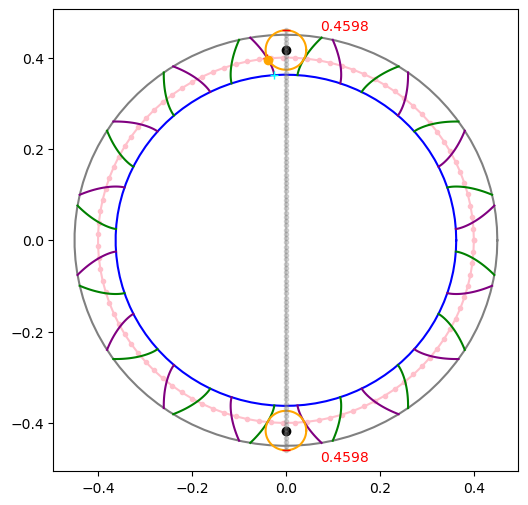

In [21]:
fig, ax = plt.subplots(figsize = (6,6))

# Base, Pitch, Addendum Circles
ax.plot(base_circ.real, base_circ.imag, color = 'blue', label = "Base Circle")
ax.plot(adden_circ.real, adden_circ.imag, color = 'grey')
ax.plot(pitch_circ.real, pitch_circ.imag, color = 'pink', marker = '.')

# Standard Orientation Involute Graphing
#invo1_left = startPt.real + (invo1 * 1j).real + (startPt.imag + (invo1 * 1j).imag) * 1j
#invo1_right = - startPt.real - (invo1 * 1j).real + (startPt.imag + (invo1 * 1j).imag) * 1j
#for n in range(vars[N]):
#    left = invo1_left * np.exp(1j * 2*np.pi/vars[N] * n)
#    right = invo1_right * np.exp(1j * 2*np.pi/vars[N] * n)
#    ax.plot(left.real, left.imag, 'purple', alpha = .3)
#    ax.plot(right.real, right.imag, 'g', alpha = .3)
    
# Adjusted Orientation Involute Graphing
invoPts = {}
for n in range(vars[N]):
    if(np.mod(vars[N],2) == 0): #even
        invo1_left = startPt.real + (invo1a).real + (startPt.imag + (invo1a).imag) * 1j
        invo1_right = - startPt.real - (invo1a).real + (startPt.imag + (invo1a).imag) * 1j
        left = invo1_left * np.exp(1j * 2*np.pi/vars[N] * n)
        right = invo1_right * np.exp(1j * 2*np.pi/vars[N] * n)
    else: # odd
        invo1_left = startPt.real - (invo1a).real + (startPt.imag + (invo1a).imag) * 1j
        invo1_right = - startPt.real + (invo1a).real + (startPt.imag + (invo1a).imag) * 1j

        #invo1_left = startPt.real - (invo1a * 1j).real + (startPt.imag + (invo1a * 1j).imag) * 1j
        #invo1_right = - startPt.real + (invo1a * 1j).real + (startPt.imag + (invo1a * 1j).imag) * 1j
        left = invo1_left * np.exp(1j * 2*np.pi/vars[N] * n)
        right = invo1_right * np.exp(1j * 2*np.pi/vars[N] * n)
        #right = invo1_left * np.exp(1j * 2*np.pi/vars[N] * n) #* np.exp(1j * np.pi/vars[N])
        #left = invo1_right * np.exp(1j * 2*np.pi/vars[N] * n) #* np.exp(1j * np.pi/vars[N])
        
    ax.plot(left.real, left.imag, 'purple')
    ax.plot(right.real, right.imag, 'g')
    invoPts[str(n) + "L"] = [left.real, left.imag]
    invoPts[str(n) + "R"] = [right.real, right.imag]


ax.plot(0, topPin_cntr.imag, marker = 'o', color = 'black')
ax.plot(botPin_cntr.real, botPin_cntr.imag, marker = 'o', color = 'black')
ax.plot(pin_circ.real, pin_circ.imag, color = 'orange')
ax.plot(pin_circ_bot.real, pin_circ_bot.imag, color = 'orange' )
mowPts = {}
mowPts["Top"] = [pin_circ.real, pin_circ.imag]
mowPts["Bot"] = [pin_circ_bot.real, pin_circ_bot.imag]

# Caliper Line
ax.plot(np.linspace(topPt.real, topPt.real - vars[mMOW] * np.cos(MOW_angle), 100), np.linspace(topPt.imag, topPt.imag - vars[mMOW] * np.sin(MOW_angle), 100), marker = ".", color = 'grey', alpha = .3)
# Top and Bottom Points
ax.plot(topPt.real, topPt.imag, 'r_')
ax.annotate(str(np.round(np.abs(topPt),4)), xy = (vars[Dbase]/10, topPt.imag), color = 'red')
ax.plot(botPt.real, botPt.imag, 'r_')
ax.annotate(str(np.round(np.abs(botPt),4)), xy = (vars[Dbase]/10, botPt.imag * 1.05), color = 'red')

ax.plot(startPt.real, startPt.imag, marker = '+', color = 'cyan')
ax.plot(controlPt.real, controlPt.imag, marker = '+', color= 'red')
ax.plot(contactPt.real, contactPt.imag, marker = 'o', color = 'orange')

np.complex128(-0.037595049597843495+0.3952904393747848j)

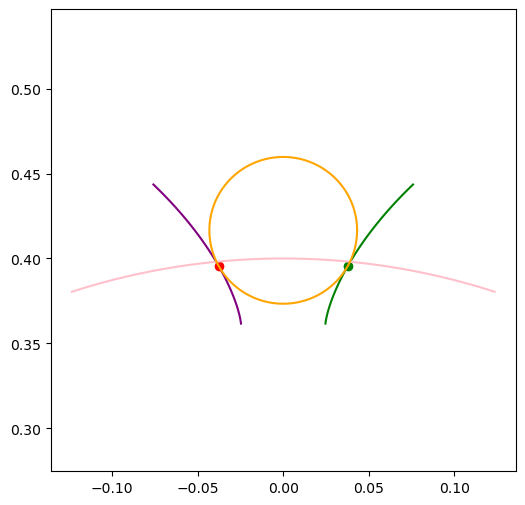

In [22]:
# Zoom in on Contact
fig1, ax1 = plt.subplots(figsize = (6,6))

left = invo1_left * np.exp(1j * 2*np.pi/vars[N] * 0)
right = invo1_right * np.exp(1j * 2*np.pi/vars[N] * vars[N])
ax1.plot(left.real, left.imag, 'purple')
ax1.plot(right.real, right.imag, 'g')
ax1.plot(contactPt.real, contactPt.imag, marker = 'o', color = 'red')

contactTest = startPt.real + (invoFunc(psi_contact, zeta = zeta) * 1j).real + (startPt.imag + (invoFunc(psi_contact, zeta = zeta) * 1j).imag) * 1j
ax1.plot(-contactTest.real, contactTest.imag, 'go')

ax1.plot(pitchFunc(np.linspace(np.pi*2/5, np.pi*3/5, 100)).real, pitchFunc(np.linspace(np.pi*2/5, np.pi*3/5, 100)).imag, color = 'pink')

ax1.plot(pin_circ.real, pin_circ.imag, color = 'orange')


# Scaling to 1x1 
if (np.average(ax1.get_xlim()) < np.average(ax1.get_ylim())):
    ax1.set_ylim( np.average(ax1.get_ylim()) - (ax1.get_xlim()[1] - ax1.get_xlim()[0])/2,
                  np.average(ax1.get_ylim()) + (ax1.get_xlim()[1] - ax1.get_xlim()[0])/2 )
else:
    ax1.set_xlim( np.average(ax1.get_xlim()) - (ax1.get_ylim()[1] - ax1.get_ylim()[0])/2,
                  np.average(ax1.get_xlim()) + (ax1.get_ylim()[1] - ax1.get_ylim()[0])/2 )
    
display(contactPt)

### Saving Curves to XYZ file 

In [23]:
# Saving all Plotted Geom
saveMe = False

if saveMe:
    x_data = 0
    y_data = 0
    ax.get_children()
    i = 0
    for geom in ax.get_children():
        i = i +1
        if isinstance(geom, plt.Line2D):
            x_data = geom.get_xdata()
            y_data = geom.get_ydata()
            line_data = {'x': x_data, 'y': y_data, 'z': 0}
            df = pd.DataFrame(line_data)
            #df = df.applymap(lambda x: 0 if x < .000000001 else x)
            df.to_csv('./plottingDataGear%s.sldcrv'%(i), index=False, sep="\t", header = False) # CHECK ME, if back/foreslash for windows     

### MOW - More Examples

In [24]:
vars = Gear2

for var in equations.keys():
    solve(var, vars, equations[var])

vars[mAlpha] = newtons(target = vars[mInvo])
vars[nAlpha] = newtons(target = vars[nInvo])

solve(mMOW, vars, emMOW)
solve(nMOW, vars, enMOW)

delt = float(s.solve(eDelta.subs(vars), Delta)[0])

In [25]:
initialGuess_basic = [1.5, .15] # <<< --- CHECK ME IF PROBLEM

startPt = vars[Dbase]/2 * np.exp(1j * ((vars[CSW]/vars[Dp]) - delt)) * 1j

# Adjust by zeta at the relative radius of base to pitch
    # Desired Trajectory
controlPt = vars[Dp] / 2 * np.exp(1j * (np.angle(startPt) + delt))
traj_desired = controlPt - startPt
    # Real Trajectory

soln_basic = sci.optimize.fsolve(basicIntersect, initialGuess_basic)
traj_basic = invoFunc(soln_basic[0], np.pi/2)
    # Solving for the zeta value of offsetting the line over
    # Unfortunately not trivial as the zeta angle pertains to the 
    #   angle of the TANGENTS of the involute curve at psi = 0
    #   (which, with the second involute unknown, isn't calculable).
    #   Additionally, the new intersect of the involute to the pitch circle
    #   occurs at a DIFFERENT psi value, so basically everything is different.

initialGuess_zeta = [np.angle(traj_desired) - np.angle(traj_basic),
                     soln_basic[0]]
soln_zeta = sci.optimize.fsolve(zetaFinding, initialGuess_zeta)
zeta = soln_zeta[0]

# Find the intersect with the Addendum to trim the graphing involute later

initialGuess_tip = [1.5, .15] # <<< --- CHECK ME IF PROBLEM
soln_tip = sci.optimize.fsolve(tipIntersect, initialGuess_tip)
psi_tip = soln_tip[0]

# Contact point of Involute & Wire
contact_xtol = 1E-7
initialGuess_contact = [.5, 3] # <<< --- CHECK ME IF PROBLEM
soln_contact = sci.optimize.fsolve(contactMOW, initialGuess_contact, xtol = contact_xtol)

contactMOW_check = np.angle(tang_invo(soln_contact[0])) - np.angle(tang_circ(soln_contact[1]))
if contactMOW_check < (contact_xtol * 1.1):
    psi_contact = soln_contact[0]
else:
    display("Contact Solver Failed to Converge as Desired")
    psi_contact = ()
contact = invoFunc(psi_contact, zeta) 
contactPt = startPt + contact * np.exp(1j * np.pi/2)

topPin_vertOffset = np.sin(np.arccos(abs((contactPt).real)/(vars[Dpin]/2))) * vars[Dpin]/2
topPin_cntr = ((contactPt).imag + abs(topPin_vertOffset)) * 1j

if(np.mod(vars[N],2) == 0): #even
    topPt = topPin_cntr + vars[Dpin]/2 * 1j
    botPin_cntr = topPin_cntr * np.exp(1j * np.pi)

    botPt = -topPt
    MOW_angle = np.angle(topPt - botPt)
else:
    botPin_cntr = topPin_cntr * np.exp(1j * np.pi * (vars[N] + 1) / (vars[N]))
    top2bot =  topPin_cntr - botPin_cntr
    MOW_angle = np.angle(topPin_cntr - botPin_cntr)
    topPt = topPin_cntr + vars[Dpin]/2 * np.exp(1j * MOW_angle)
    botPt = botPin_cntr - vars[Dpin]/2 * np.exp(1j * MOW_angle)

In [26]:
theta_circ =  np.linspace(0, 2*np.pi, 100)
psi_param = np.linspace(0, psi_tip, 100)

base_circ = 0 + baseFunc(theta_circ)
adden_circ = 0 + addenFunc(theta_circ)
pin_circ_0 =  0 + pinFunc(theta_circ)
pitch_circ = 0 + pitchFunc(theta_circ)
invo1 = invoFunc(psi_param, offsetAng= np.pi/2)

# Zeta is inverted for odd vs even teeth!
invo1a = invoFunc(psi_param, offsetAng = np.pi/2, zeta = zeta * (1 if np.mod(vars[N],2) == 0 else -1))
pin_circ = topPin_cntr + pin_circ_0
pin_circ_bot = botPin_cntr + pin_circ_0

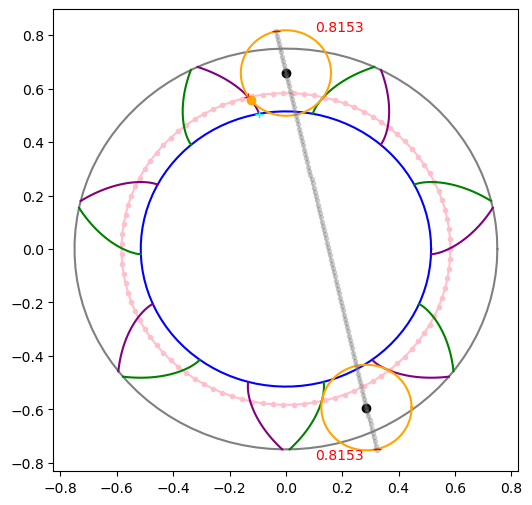

In [27]:
fig, ax = plt.subplots(figsize = (6,6))

# Base, Pitch, Addendum Circles
ax.plot(base_circ.real, base_circ.imag, color = 'blue', label = "Base Circle")
ax.plot(adden_circ.real, adden_circ.imag, color = 'grey')
ax.plot(pitch_circ.real, pitch_circ.imag, color = 'pink', marker = '.')

# Standard Orientation Involute Graphing
#invo1_left = startPt.real + (invo1 * 1j).real + (startPt.imag + (invo1 * 1j).imag) * 1j
#invo1_right = - startPt.real - (invo1 * 1j).real + (startPt.imag + (invo1 * 1j).imag) * 1j
#for n in range(vars[N]):
#    left = invo1_left * np.exp(1j * 2*np.pi/vars[N] * n)
#    right = invo1_right * np.exp(1j * 2*np.pi/vars[N] * n)
#    ax.plot(left.real, left.imag, 'purple', alpha = .3)
#    ax.plot(right.real, right.imag, 'g', alpha = .3)
    
# Adjusted Orientation Involute Graphing
invoPts = {}
for n in range(vars[N]):
    if(np.mod(vars[N],2) == 0): #even
        invo1_left = startPt.real + (invo1a).real + (startPt.imag + (invo1a).imag) * 1j
        invo1_right = - startPt.real - (invo1a).real + (startPt.imag + (invo1a).imag) * 1j
        left = invo1_left * np.exp(1j * 2*np.pi/vars[N] * n)
        right = invo1_right * np.exp(1j * 2*np.pi/vars[N] * n)
    else: # odd
        invo1_left = startPt.real - (invo1a).real + (startPt.imag + (invo1a).imag) * 1j
        invo1_right = - startPt.real + (invo1a).real + (startPt.imag + (invo1a).imag) * 1j

        #invo1_left = startPt.real - (invo1a * 1j).real + (startPt.imag + (invo1a * 1j).imag) * 1j
        #invo1_right = - startPt.real + (invo1a * 1j).real + (startPt.imag + (invo1a * 1j).imag) * 1j
        left = invo1_left * np.exp(1j * 2*np.pi/vars[N] * n)
        right = invo1_right * np.exp(1j * 2*np.pi/vars[N] * n)
        #right = invo1_left * np.exp(1j * 2*np.pi/vars[N] * n) #* np.exp(1j * np.pi/vars[N])
        #left = invo1_right * np.exp(1j * 2*np.pi/vars[N] * n) #* np.exp(1j * np.pi/vars[N])
        
    ax.plot(left.real, left.imag, 'purple')
    ax.plot(right.real, right.imag, 'g')
    invoPts[str(n) + "L"] = [left.real, left.imag]
    invoPts[str(n) + "R"] = [right.real, right.imag]


ax.plot(0, topPin_cntr.imag, marker = 'o', color = 'black')
ax.plot(botPin_cntr.real, botPin_cntr.imag, marker = 'o', color = 'black')
ax.plot(pin_circ.real, pin_circ.imag, color = 'orange')
ax.plot(pin_circ_bot.real, pin_circ_bot.imag, color = 'orange' )
mowPts = {}
mowPts["Top"] = [pin_circ.real, pin_circ.imag]
mowPts["Bot"] = [pin_circ_bot.real, pin_circ_bot.imag]

# Caliper Line
ax.plot(np.linspace(topPt.real, topPt.real - vars[mMOW] * np.cos(MOW_angle), 100), np.linspace(topPt.imag, topPt.imag - vars[mMOW] * np.sin(MOW_angle), 100), marker = ".", color = 'grey', alpha = .3)
# Top and Bottom Points
ax.plot(topPt.real, topPt.imag, 'r_')
ax.annotate(str(np.round(np.abs(topPt),4)), xy = (vars[Dbase]/10, topPt.imag), color = 'red')
ax.plot(botPt.real, botPt.imag, 'r_')
ax.annotate(str(np.round(np.abs(botPt),4)), xy = (vars[Dbase]/10, botPt.imag * 1.05), color = 'red')

ax.plot(startPt.real, startPt.imag, marker = '+', color = 'cyan')
ax.plot(controlPt.real, controlPt.imag, marker = '+', color= 'red')
ax.plot(contactPt.real, contactPt.imag, marker = 'o', color = 'orange')

## MBW Max/Min

Following the same process as MOW, but with formulas modified for internal profile:

$\Theta_{m|n} = \frac{CSW_{m|n}}{D_P} + (tan(\beta) - \beta) - \frac{D_{pin}}{D_{base}}$

$\Theta_{m|n} = tan(\alpha_{m|n}) - \alpha_{m|n}$

* For Even Teeth:

$MBW_{m|n} = \frac{D_{base}}{cos(\alpha_{m|n})} - D_{pin}$

* For Odd Teeth:

$MBW_{m|n}= \frac{D_{base}}{cos(\alpha_{m|n})} \times cos(\frac{\pi}{2 N}) - D_{pin}$

_...(graphical tbd)..._